# Model Improvement After Feedback (10/09)

We show the desired outcome (**L1** and **L2** products on the full time series) with the continuous integration setup.  

To reduce the willingness of the data, we add a local filter which consider as outlier an observation based on the local delta distribution.

We will only consider the **forecasted data**, since the retroactive gapfilled data are identical.  

---

## Improvements

The improvements are the following:  

- adding a local filter to reduce the data willingness
- Including a multiplicative factor to avoid unwanted behavior  
- Testing the three different smoothing options


In [1]:
from IPython.display import IFrame, Image, display
import numpy as np
import math
import zarr
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import xarray as xr
import torch
import torch.nn as nn
import pandas as pd
from scipy.signal import savgol_filter
import gc
import imageio
from io import BytesIO
from rasterio import features
from affine import Affine
from functions import *

This is the full gapfilled time serie with the smoothing using Savitzky Golay

/home/francesco/miniconda3/envs/ndvi/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


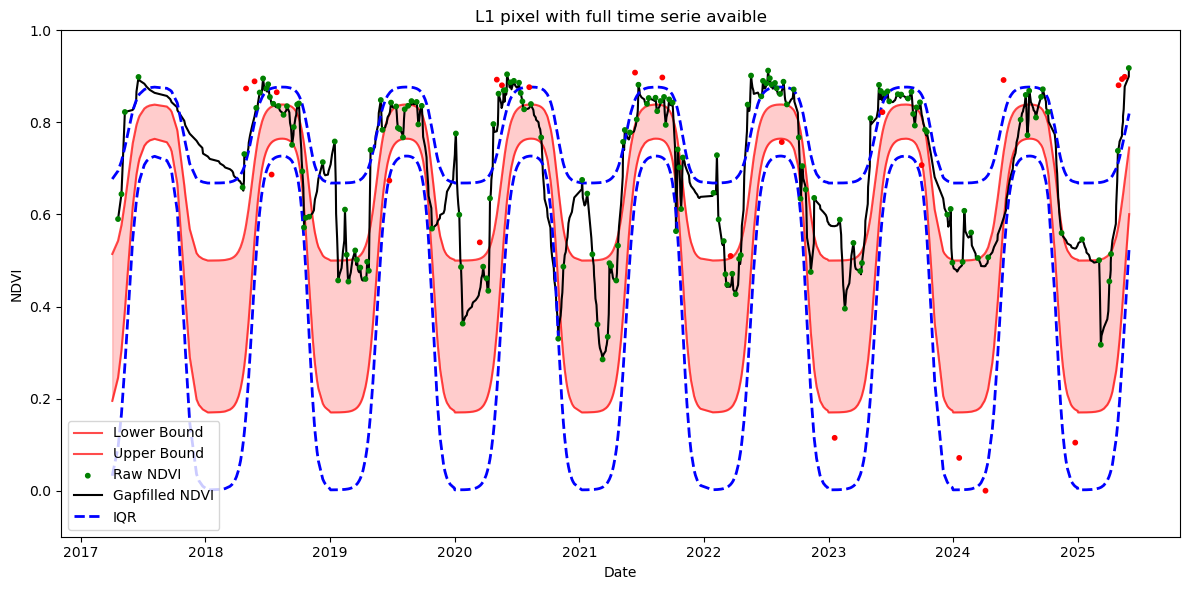

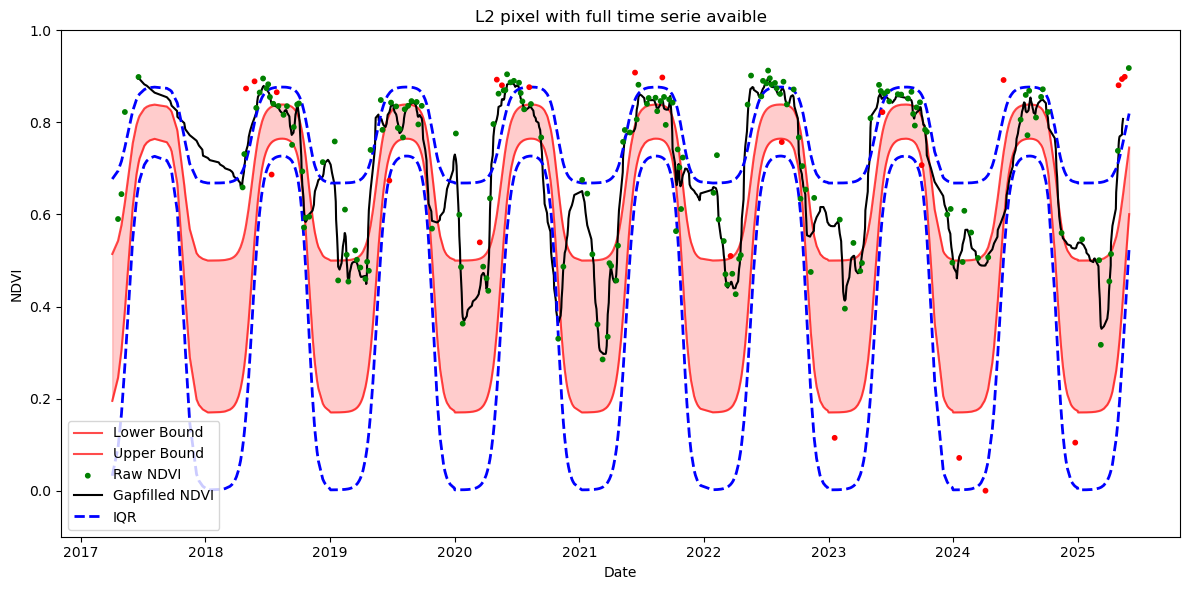

In [2]:
# data loading and raster initialization
# ----- Config -----
zarr_path = "../pixel_biomes.zarr/ndvi"

z = zarr.open(zarr_path, mode="r")

# fitting and smoothing
# ----- seasonal cycle fitting -----
ds = xr.open_zarr("../../sample_seasonal_cycle_parameter_preds.zarr")
ndvi = ds["ndvi"]
dates = ds["dates"]
params_lower = torch.tensor(ds["params_lower"].values)
params_upper = torch.tensor(ds["params_upper"].values)

# convert dates to doy
dates_pd = pd.to_datetime(dates)
df = pd.DataFrame({"date": dates_pd})
df_sorted = df.sort_values(by="date")
dates_sorted = df_sorted["date"].values
dates_pd_sorted = pd.to_datetime(dates_sorted)
doy = dates_pd_sorted.dayofyear.values
doy = torch.tensor(doy, dtype=torch.float32)
T_SCALE = 1.0 / 365.0
t = doy.unsqueeze(0).repeat(params_lower.shape[0], 1) * T_SCALE


lower = double_logistic_function(t[[0]], params_lower[[91]]).squeeze().cpu().numpy()
upper = double_logistic_function(t[[0]], params_upper[[91]]).squeeze().cpu().numpy()

median_iqr = upper - (upper - lower) / 2

param_iqr = 1.02
bottom_iqr = 0.2
upper_iqr = 0.8
window_length = 14
polyorder = 2

random_pixels = 120  # pick one pixel index to check

ndvi_series = z[random_pixels, :]

# proper sorting

df = pd.DataFrame({
    'date': dates_pd,
    'ndvi': ndvi_series
    })

df_sorted = df.sort_values(by='date')

ndvi_sorted = df_sorted['ndvi'].values

ndvi_gapfilled, outlier_arr, q_hi, q_low = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=False,
                                            param_iqr=1.02,bottom_q=0.4,
                                            top_q=0.6,return_quantiles = True, weight_median = 0.5)

smoothed_data = savgol_filter(ndvi_gapfilled, window_length=window_length, polyorder=polyorder) 


plot_results(
        title= "L1 pixel with full time serie avaible",
        ndvi_series=ndvi_sorted / 10000.0,
        ndvi_gapfilled=ndvi_gapfilled,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted,
        show_iqr= True,
        param_iqr = param_iqr
    )

plot_results(
        title= "L2 pixel with full time serie avaible",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed_data,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted,
        show_iqr= True,
        param_iqr = param_iqr
    )


This is the continous integration as shown in the previous notebook

In [3]:
ndvi_filled, outlier_arr, forecast_only, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=True,
                                                                param_iqr=1.5,
                                                                bottom_q=0.3,
                                                                top_q=0.7,
                                                                weight_median = 0.5,
                                                                q_hi = q_hi, q_low = q_low, 
                                                                window_smoothing = 14,
                                                                lag_forecast= 14,)



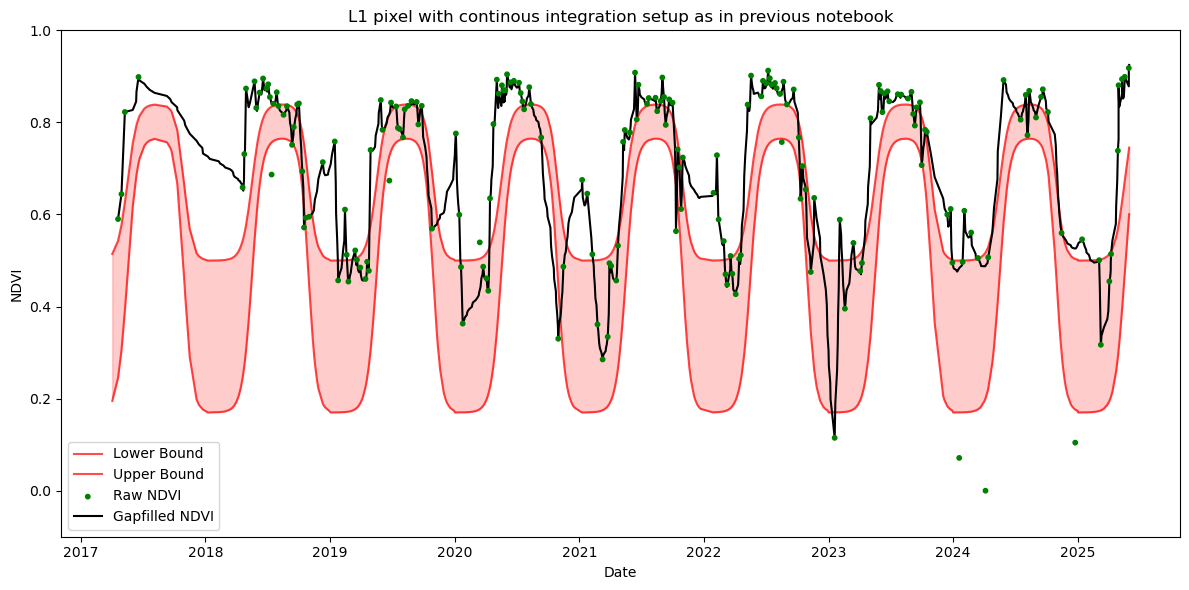

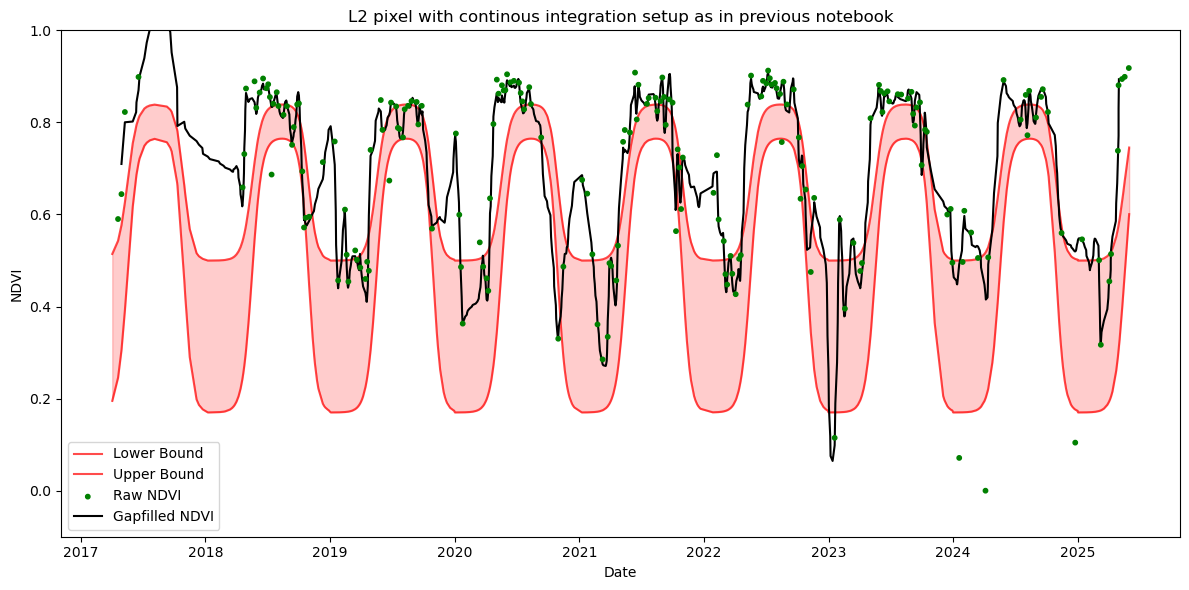

In [4]:
ndvi_filled, outlier_arr, forecast_only, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=True,
                                                                param_iqr=1.5,
                                                                bottom_q=0.3,
                                                                top_q=0.7,
                                                                weight_median = 0.5,
                                                                q_hi = q_hi, q_low = q_low, 
                                                                window_smoothing = 14,
                                                                lag_forecast= 14,)

plot_results(
        title= "L1 pixel with continous integration setup as in previous notebook",
        ndvi_series=ndvi_sorted / 10000.0,
        ndvi_gapfilled=forecast_only,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

plot_results(
        title= "L2 pixel with continous integration setup as in previous notebook",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

increase window smoothing to 28

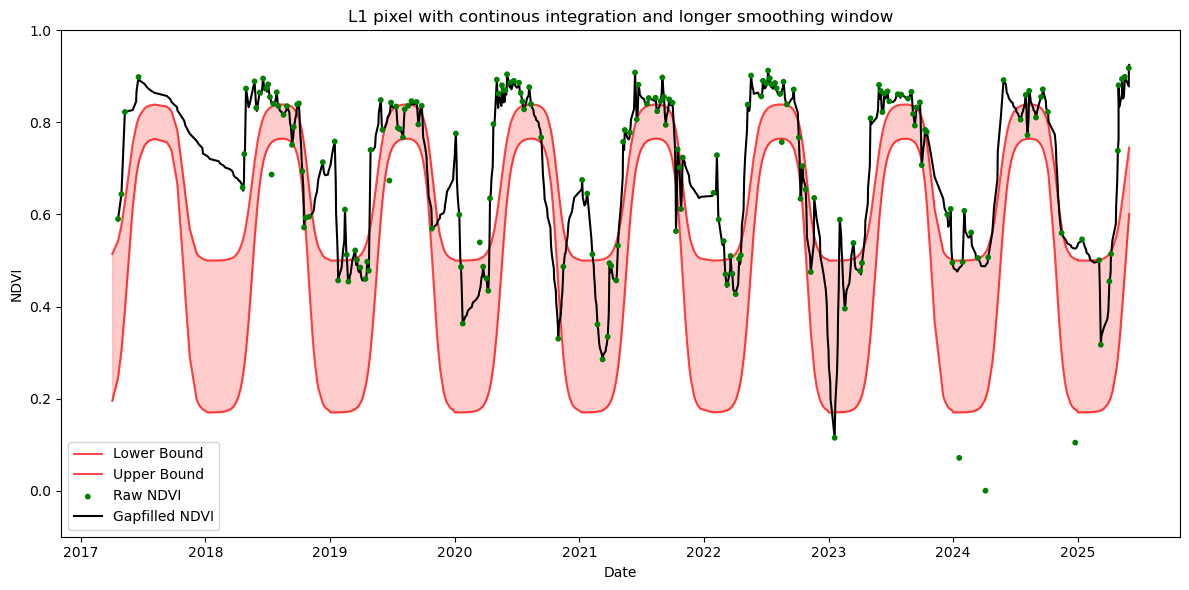

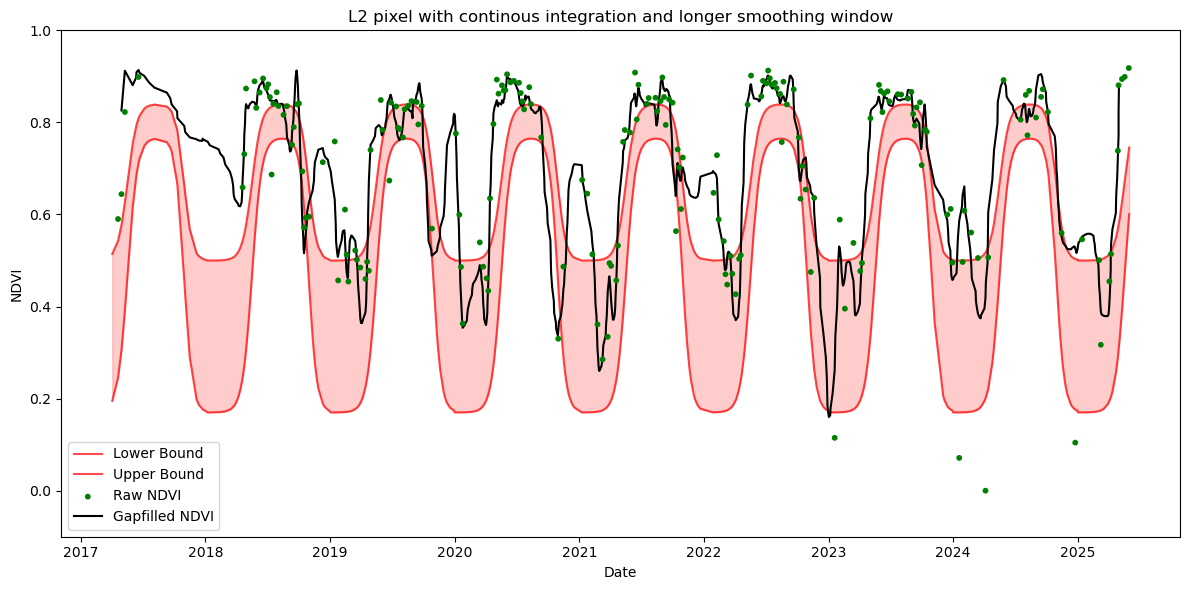

In [5]:
ndvi_filled, outlier_arr, forecast_only, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=True,
                                                                param_iqr=1.5,
                                                                bottom_q=0.3,
                                                                top_q=0.7,
                                                                weight_median = 0.5,
                                                                q_hi = q_hi, q_low = q_low,                                                                 
                                                                window_smoothing = 28,
                                                                lag_forecast= 14)

plot_results(
        title= "L1 pixel with continous integration and longer smoothing window",
        ndvi_series=ndvi_sorted / 10000.0,
        ndvi_gapfilled=forecast_only,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

plot_results(
        title= "L2 pixel with continous integration and longer smoothing window",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

increase window lag days before smoothing to 28

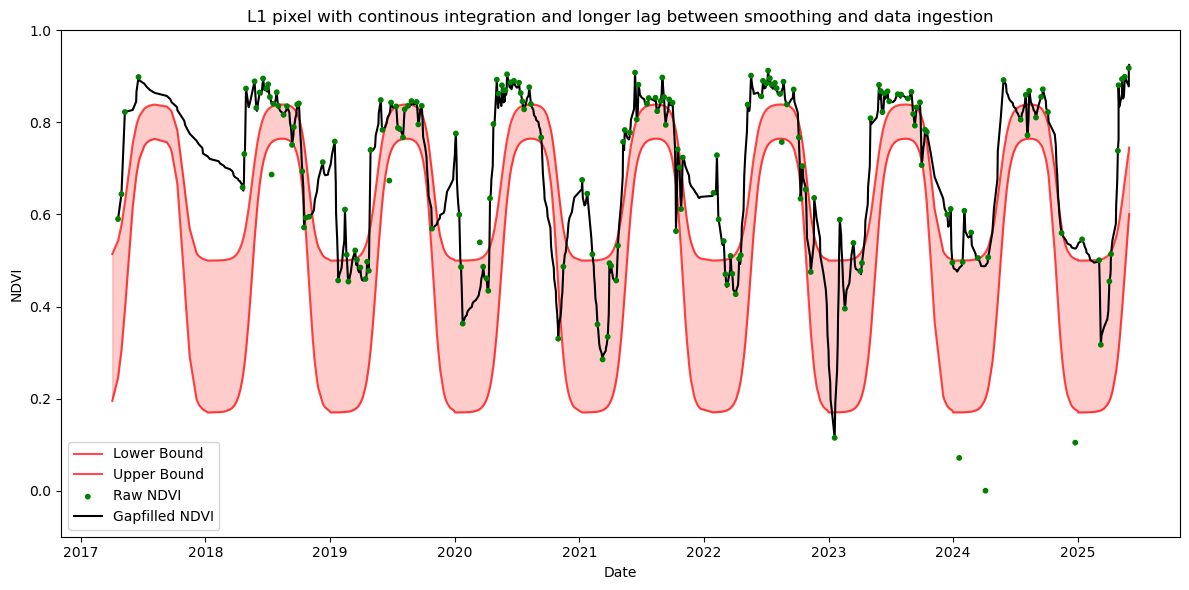

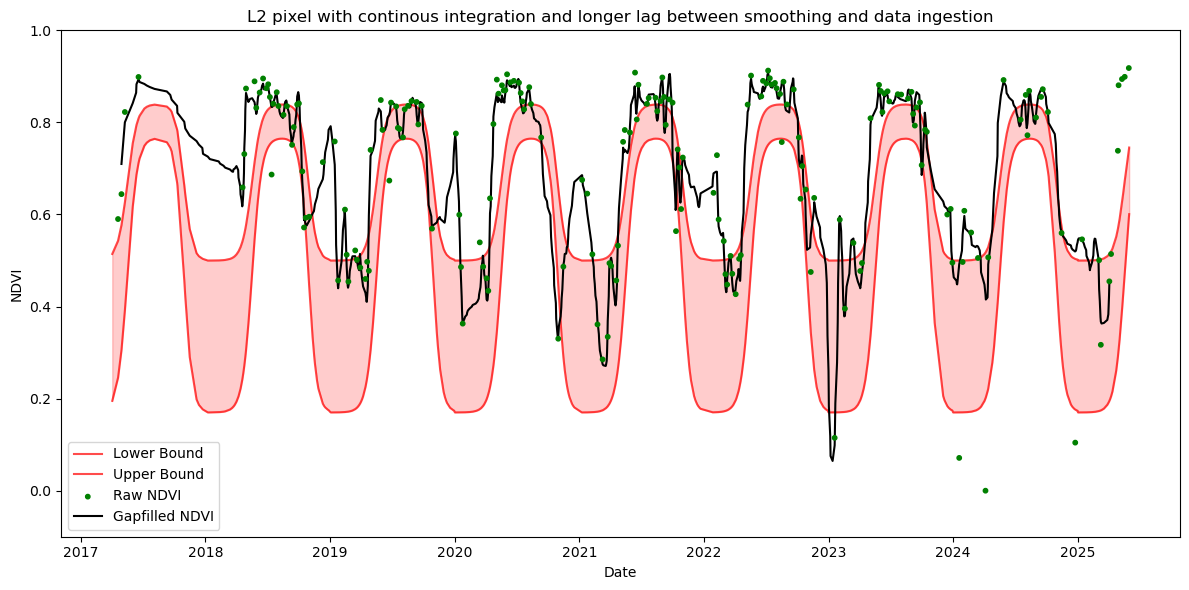

In [6]:
ndvi_filled, outlier_arr, forecast_only, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=True,
                                                                param_iqr=1.5,
                                                                bottom_q=0.3,
                                                                top_q=0.7,
                                                                weight_median = 0.5,
                                                                q_hi = q_hi, q_low = q_low, 
                                                                window_smoothing = 14,
                                                                lag_forecast= 28)

plot_results(
        title= "L1 pixel with continous integration and longer lag between smoothing and data ingestion",
        ndvi_series=ndvi_sorted / 10000.0,
        ndvi_gapfilled=forecast_only,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

plot_results(
        title= "L2 pixel with continous integration and longer lag between smoothing and data ingestion",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

Increasing the smoothing window or the lag between the ingested data and the smoothing does not improve the smoothing performance.  
Therefore, it is necessary to adopt a realistic representation of the continuous L1 product.  

We propose an exponential decay factor that depends on the lag days (the time difference between the current day and the last known true value).  

The factor starts at **1** when the lag is minimal and decreases toward **0** as the lag increases, following the formula:  

$$
f = e^{-\ln(2) \cdot ( \text{lag\_days} / \tau )}
$$

The factor has one parameter **$\tau$**, indicating the lag at which the factor has a value of 0.5.

This factor is then multiplied by the last known delta, allowing the data to gradually converge toward the center of the band as the lag increases.


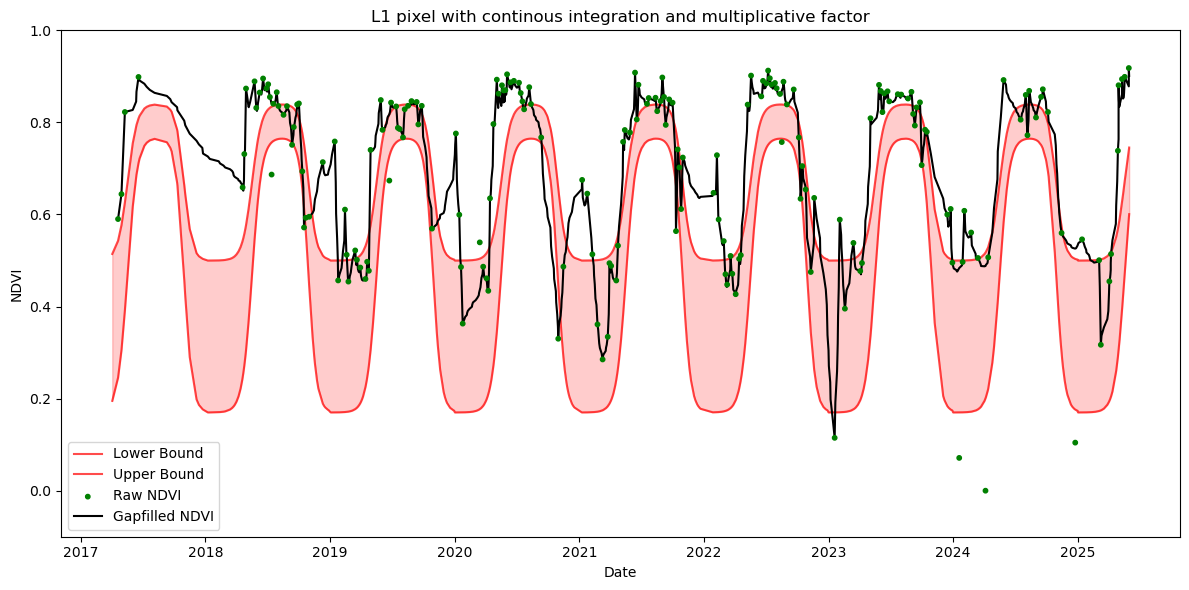

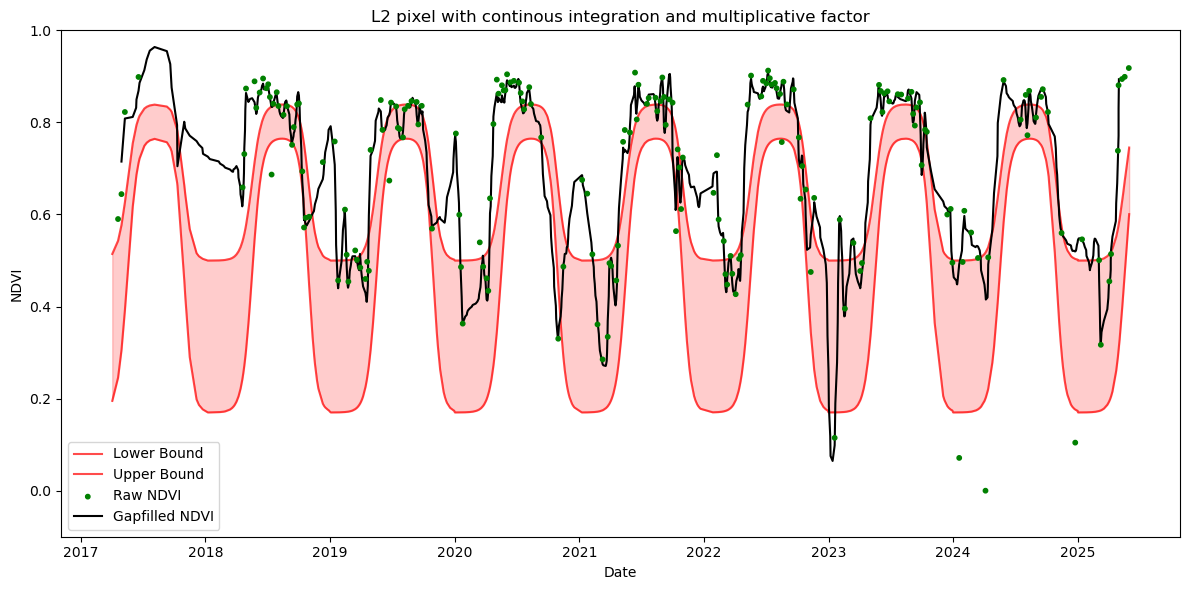

In [7]:
ndvi_filled, outlier_arr, forecast_only, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=True,
                                                                param_iqr=1.5,
                                                                bottom_q=0.3,
                                                                top_q=0.7,
                                                                weight_median = 0.5,
                                                                q_hi = q_hi, q_low = q_low, 
                                                                smoothing_method = "savgol",
                                                                window_smoothing = 14,
                                                                use_tau=True,
                                                                tau = 7)

plot_results(
        title= "L1 pixel with continous integration and multiplicative factor",
        ndvi_series=ndvi_sorted / 10000.0,
        ndvi_gapfilled=forecast_only,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

plot_results(
        title= "L2 pixel with continous integration and multiplicative factor",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

smoothing option with low pass filter

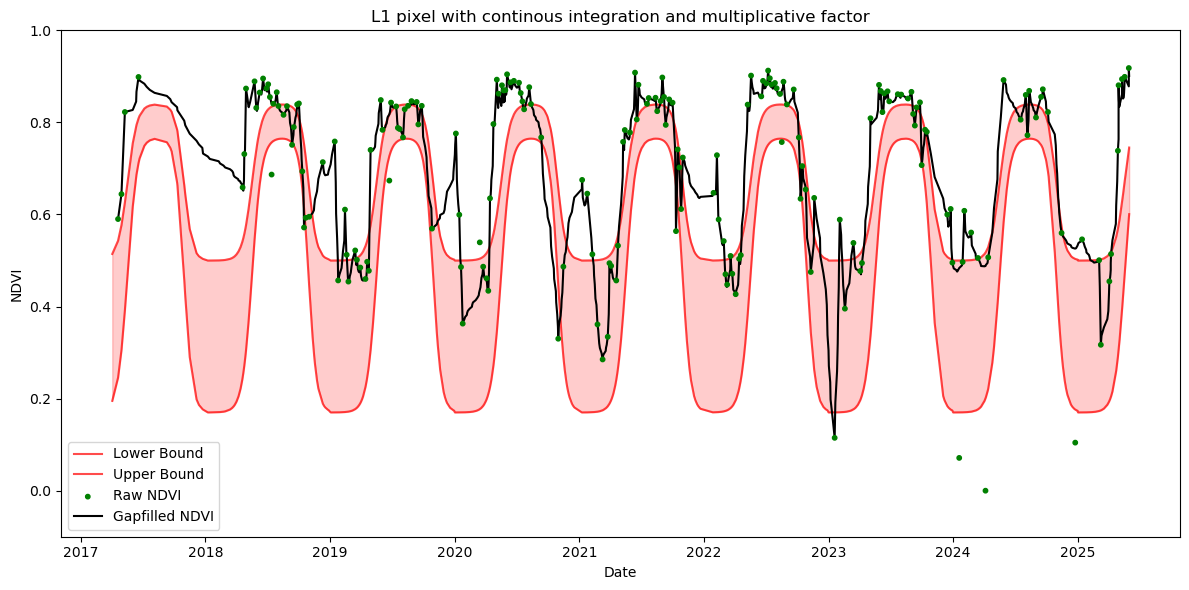

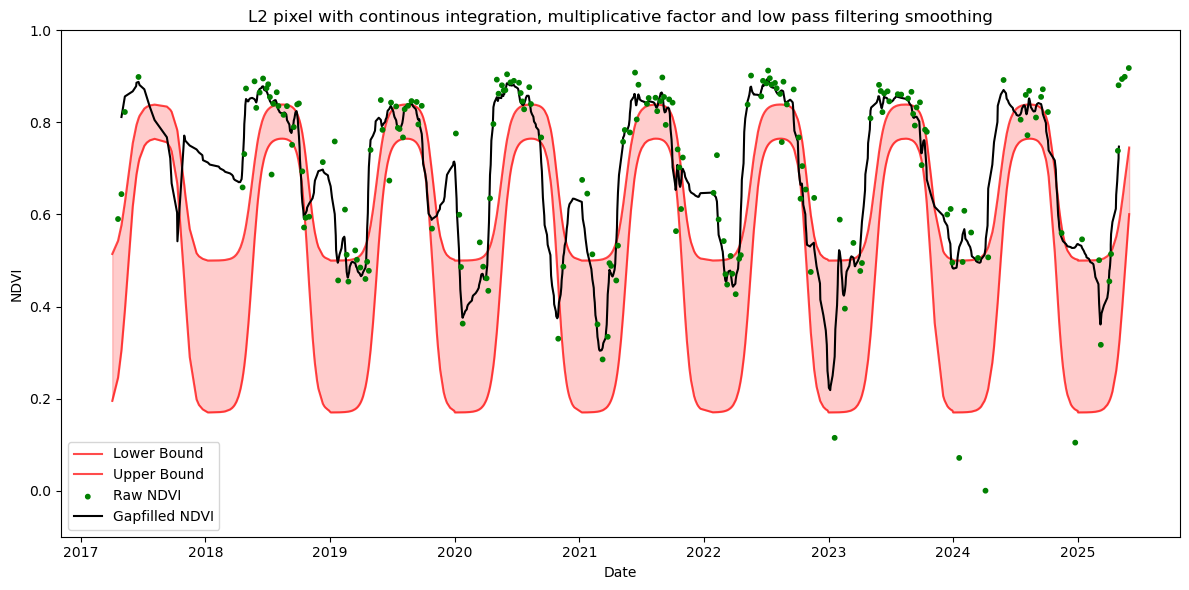

In [8]:
ndvi_filled, outlier_arr, forecast_only, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=True,
                                                                param_iqr=1.5,
                                                                bottom_q=0.3,
                                                                top_q=0.7,
                                                                weight_median = 0.5,
                                                                q_hi = q_hi, q_low = q_low, 
                                                                smoothing_method= "low_pass",
                                                                window_smoothing = 14,
                                                                sigma = 4,
                                                                use_tau=True,
                                                                tau = 7)

plot_results(
        title= "L1 pixel with continous integration and multiplicative factor",
        ndvi_series=ndvi_sorted / 10000.0,
        ndvi_gapfilled=forecast_only,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

plot_results(
        title= "L2 pixel with continous integration, multiplicative factor and low pass filtering smoothing",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

smoothig with loess

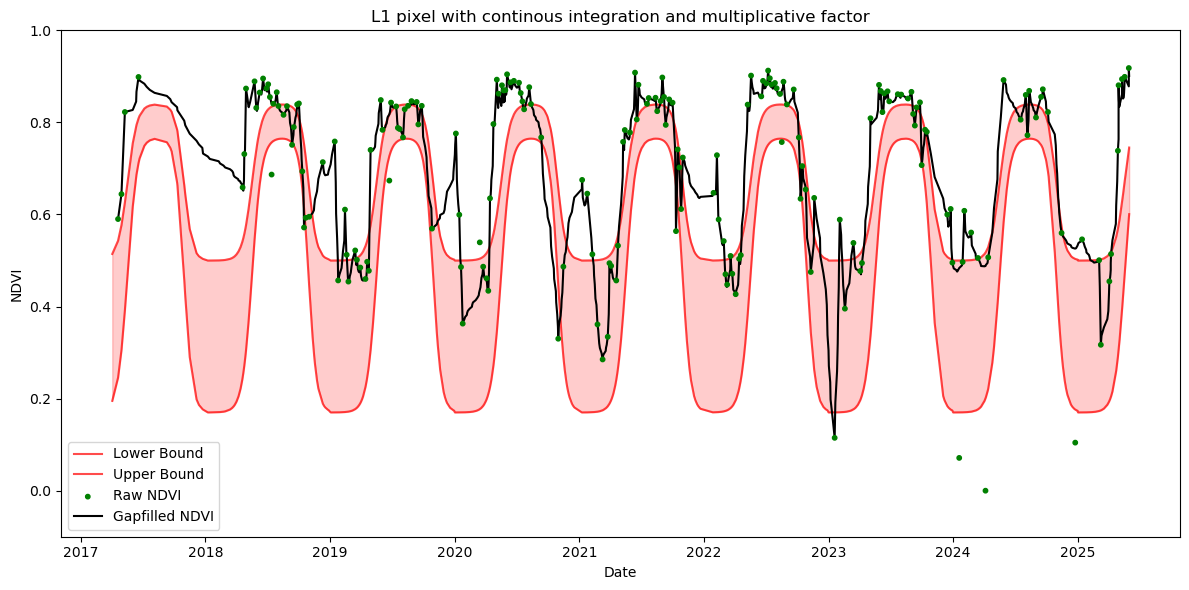

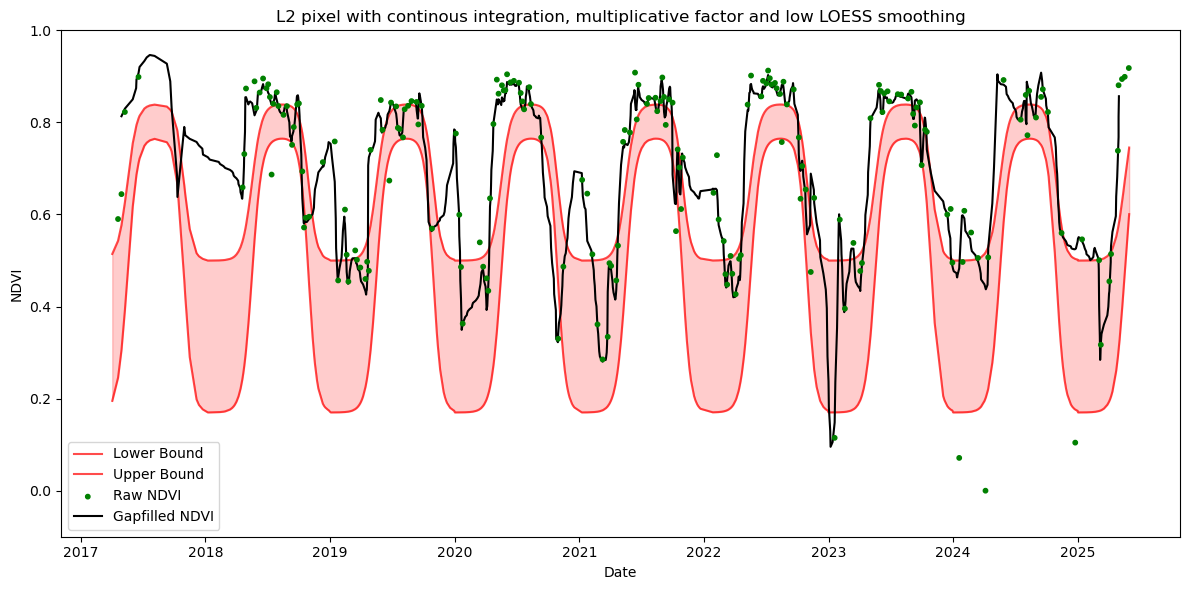

In [10]:
ndvi_filled, outlier_arr, forecast_only, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=True,
                                                                param_iqr=1.5,
                                                                bottom_q=0.3,
                                                                top_q=0.7,
                                                                weight_median = 0.5,
                                                                q_hi = q_hi, q_low = q_low, 
                                                                smoothing_method= "loess",
                                                                window_smoothing = 14,
                                                                frac = 0.9,
                                                                use_tau=True,
                                                                tau = 7)

plot_results(
        title= "L1 pixel with continous integration and multiplicative factor",
        ndvi_series=ndvi_sorted / 10000.0,
        ndvi_gapfilled=forecast_only,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

plot_results(
        title= "L2 pixel with continous integration, multiplicative factor and low LOESS smoothing",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )